In this notebook, we read the pixels of the noisy image with modified space-filling curve. We then apply the fast Fourier transform of the one-dimensional signal obtained by passing an input picture with modified Sierpinski space-filling curve. We use periodic space-filling curve because Fourier transform assumes the transformed signal to be periodic. Our goal is to see whether using lower harmonics will be enough to capture most of image information and obtain more clear image.

We write a function that can be used to read an image with modified Sierpinski space-filling curve. 

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import copy

%matplotlib inline

# N is the order of the curve (see sierpinski.ipynb for details)
def modified_sierpinski_curve(N, plot_curve = True):
    #initialize arrays
    dx = np.zeros(2**(2*N), dtype=int)
    dy = np.zeros(2**(2*N), dtype=int)
    x = np.zeros(2**(2*N), dtype=int)
    y = np.zeros(2**(2*N), dtype=int)
    
    # directions of curve 
    dx[0:8] = [1, 0, 1, 1, 0, -1, 1, 0] 
    dy[0:8] = [0, -1, 1, 0, -1, 0, -1, -1]
    
    #building fractal curve
    for n in range(2,N):
        dx[2**(2*n-1):2**(2*n)] = -dy[0:2**(2*n-1)]
        dy[2**(2*n-1):2**(2*n)] = dx[0:2**(2*n-1)]
        dx[2**(2*n-1)] = 1
        dy[2**(2*n-1)] = 1
        dx[2**(2*n):2**(2*n+1)] = dy[0:2**(2*n)]
        dy[2**(2*n):2**(2*n+1)] = -dx[0:2**(2*n)]
    

    dx[2**(2*N-1):2**(2*N)] = -dx[0:2**(2*N-1)]
    dy[2**(2*N-1):2**(2*N)] = -dy[0:2**(2*N-1)]

    for i in range(2**(2*N)-1):
        x[i+1] = x[i] + dx[i]
        y[i+1] = y[i] + dy[i]
    
    if plot_curve:
        plt.plot(x,y)
        plt.show()
        
    return x, y

Let's produce a gray noisy image from the original color image.

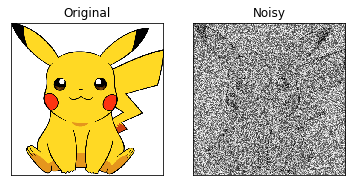

In [118]:
original = cv2.imread("images/pika.png",cv2.IMREAD_COLOR) 
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB) # OpenCV uses BGR as its default colour order for images, matplotlib uses RGB
                                                     # we need to conver it back to RGB

img = cv2.imread("images/pika.png",cv2.IMREAD_GRAYSCALE) # convert RGB image to gray
noised = (img + 800 * np.random.rand(*img.shape).astype(np.float32)) # add Gaussian noise


plt.subplot(121),plt.imshow(original),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(noised, cmap = 'gray'),plt.title('Noisy')
plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:

img = noised
image = np.array(img)
num_px = image.shape[0] #square image
print(image.shape)
N = math.log10(num_px) / math.log10(2)
N = int(N)
print("N = " + str(N))


The image can be decomposed into a weighted sum of sinusoids and cosinuoids of different frequency. 
Due to the property of Fourier expansions, higher Fourier harmonics carry less information about the data than lower harmonics. We claim that only the latter may be used without large decrease in the accuracy of the classification algorithm. 

In [99]:
x, y = modified_sierpinski_curve(N, plot_curve=False)
data = np.zeros((2**(2*N)), dtype=int)
for i in range(2**(2*N)-1):
    data[i] = image[-y[i],x[i]]

    
f = np.fft.rfft(data)
print("len(f): " + str(len(f)))
cut = 120000 
alpha = 0.1/cut # weights
for i in range(len(f)-cut, len(f)):
    f[i] = f[i]*np.exp(-((i-len(f)+cut)**2)*alpha)    

len(f): 131073


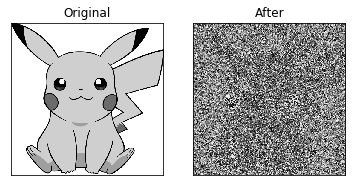

In [113]:
d  = np.fft.irfft(f, len(data))
img_back = copy.deepcopy(img)

for ii in range(2**(2*N)-1):
    img_back[-y[ii],x[ii]] = d[ii].real


plt.subplot(121),plt.imshow(img, cmap = 'gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray'),plt.title('After')
plt.xticks([]), plt.yticks([])
plt.show()